In [27]:
!pip install -q bilby==2.2.2 matplotlib==3.7.3 dynesty==2.1.2 corner==2.2.2
!pip install gwpy

import numpy as np
import matplotlib.pyplot as plt

import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries


In [28]:
!pip install gwpy lalsuite

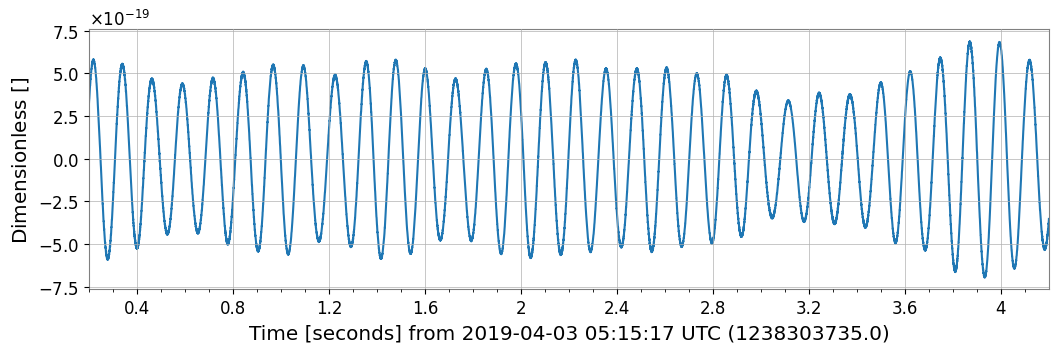

In [29]:
time_of_event = 1238303737.2
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

# Define times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2
duration = 4
analysis_start = time_of_event + post_trigger_duration - duration

# Use gwpy to fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_start + duration, sample_rate=4096, cache=True)

H1_analysis_data.plot()
plt.show()


In [30]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_start_time + psd_duration, sample_rate=4096, cache=True)

psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)


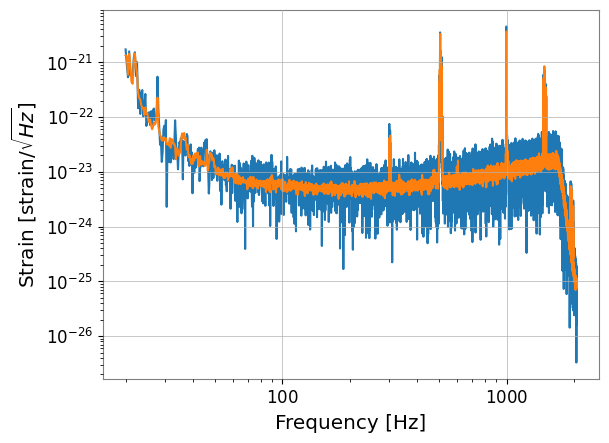

In [31]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

H1.maximum_frequency = 1024
L1.maximum_frequency = 1024


In [32]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] = Uniform(name='a_1', minimum=0, maximum=1)
prior['a_2'] = Uniform(name='a_2', minimum=0, maximum=1)
prior['tilt_1'] = Uniform(name='tilt_1', minimum=0, maximum=np.pi)
prior['tilt_2'] = Uniform(name='tilt_2', minimum=0, maximum=np.pi)
prior['phi_12'] = 0.0
prior['phi_jl'] = 0.0
prior['dec'] = -1.2232
prior['ra'] = 2.19432
prior['theta_jn'] = 1.89694
prior['psi'] = 0.532268
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')


In [33]:
# Put our "data" into a list of interferometers (the order is arbitrary)
interferometers = [H1, L1]

# Create a dictionary of arguments for the LALSimulation waveform
waveform_arguments = dict(
    waveform_approximant='IMRPhenomXP', reference_frequency=100., catch_waveform_errors=True)

# Create a waveform_generator object
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Create our likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

result = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='spin_analysis', label="GW190403_spin",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=250, dlogz=1.,  # Arguments are used to make things fast - not recommended for general use
    clean=True,
)


01:19 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
01:19 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.
01:19 bilby INFO    : Running for label 'GW190403_spin', output will be saved to 'spin_analysis'
01:19 bilby INFO    : Using lal version 7.5.0
01:19 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.22;Id: 5c23000593918e5e4ef2ff809eccc1722b5d0795;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
01:19 bilby INFO    : Using lalsimulation version 5.4.0
01:19 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.22;Id: 5c23000593918e5e4ef2ff809eccc1722b5d0795;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
01:19 bilby INFO    : Analysis priors

1it [00:00, ?it/s]

01:21 bilby INFO    : Written checkpoint file spin_analysis/GW190403_spin_resume.pickle
01:31 bilby INFO    : Written checkpoint file spin_analysis/GW190403_spin_resume.pickle
01:38 bilby INFO    : Written checkpoint file spin_analysis/GW190403_spin_resume.pickle
01:38 bilby INFO    : Rejection sampling nested samples to obtain 208 posterior samples
01:38 bilby INFO    : Sampling time: 0:18:04.063834
01:38 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/208 [00:00<?, ?it/s]

01:38 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/208 [00:00<?, ?it/s]

01:38 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/208 [00:00<?, ?it/s]

01:38 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/208 [00:00<?, ?it/s]

01:39 bilby INFO    : Summary of results:
nsamples: 208
ln_noise_evidence: -8291.985
ln_evidence: -8282.368 +/-  0.211
ln_bayes_factor:  9.617 +/-  0.211



In [34]:
result.posterior

a_1 = result.posterior["a_1"].values
a_2 = result.posterior["a_2"].values
tilt_1 = result.posterior["tilt_1"].values
tilt_2 = result.posterior["tilt_2"].values
mass_1 = result.posterior["mass_1"].values
mass_2 = result.posterior["mass_2"].values

a_1_lower_bound = np.quantile(a_1, 0.05)
a_1_upper_bound = np.quantile(a_1, 0.95)
a_1_median = np.quantile(a_1, 0.5)

a_2_lower_bound = np.quantile(a_2, 0.05)
a_2_upper_bound = np.quantile(a_2, 0.95)
a_2_median = np.quantile(a_2, 0.5)

tilt_1_lower_bound = np.quantile(tilt_1, 0.05)
tilt_1_upper_bound = np.quantile(tilt_1, 0.95)
tilt_1_median = np.quantile(tilt_1, 0.5)

tilt_2_lower_bound = np.quantile(tilt_2, 0.05)
tilt_2_upper_bound = np.quantile(tilt_2, 0.95)
tilt_2_median = np.quantile(tilt_2, 0.5)

mass_1_lower_bound = np.quantile(mass_1, 0.05)
mass_1_upper_bound = np.quantile(mass_1, 0.95)
mass_1_median = np.quantile(mass_1, 0.5)

mass_2_lower_bound = np.quantile(mass_2, 0.05)
mass_2_upper_bound = np.quantile(mass_2, 0.95)
mass_2_median = np.quantile(mass_2, 0.5)

print("a_1 = {} with a 90% C.I = {} -> {}".format(a_1_median, a_1_lower_bound, a_1_upper_bound))
print("a_2 = {} with a 90% C.I = {} -> {}".format(a_2_median, a_2_lower_bound, a_2_upper_bound))
print("tilt_1 = {} with a 90% C.I = {} -> {}".format(tilt_1_median, tilt_1_lower_bound, tilt_1_upper_bound))
print("tilt_2 = {} with a 90% C.I = {} -> {}".format(tilt_2_median, tilt_2_lower_bound, tilt_2_upper_bound))
print("mass_1 = {} with a 90% C.I = {} -> {}".format(mass_1_median, mass_1_lower_bound, mass_1_upper_bound))
print("mass_2 = {} with a 90% C.I = {} -> {}".format(mass_2_median, mass_2_lower_bound, mass_2_upper_bound))


a_1 = 0.7275196283276075 with a 90% C.I = 0.2567058247273976 -> 0.97473412301989
a_2 = 0.6122556401013767 with a 90% C.I = 0.05138808562916519 -> 0.9717874592719468
tilt_1 = 0.9097836942520516 with a 90% C.I = 0.12520002911947045 -> 2.0225566278903253
tilt_2 = 1.386408456015398 with a 90% C.I = 0.3282333131950165 -> 2.720770472995079
mass_1 = 42.496110867004575 with a 90% C.I = 36.38030244864665 -> 50.03244017942373
mass_2 = 30.699280025871566 with a 90% C.I = 26.29349909023234 -> 35.73699046501657


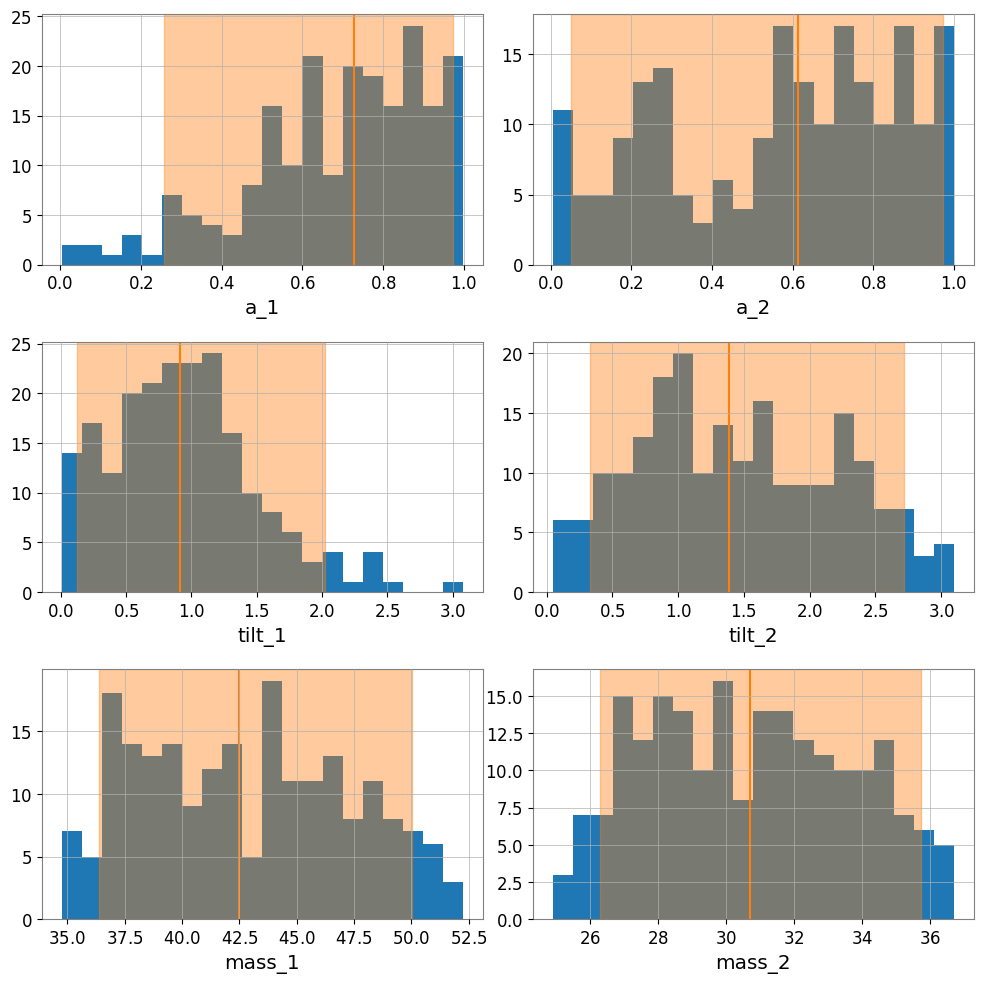

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(10, 10))

ax[0, 0].hist(a_1, bins=20)
ax[0, 0].axvspan(a_1_lower_bound, a_1_upper_bound, color='C1', alpha=0.4)
ax[0, 0].axvline(a_1_median, color='C1')
ax[0, 0].set_xlabel("a_1")

ax[0, 1].hist(a_2, bins=20)
ax[0, 1].axvspan(a_2_lower_bound, a_2_upper_bound, color='C1', alpha=0.4)
ax[0, 1].axvline(a_2_median, color='C1')
ax[0, 1].set_xlabel("a_2")

ax[1, 0].hist(tilt_1, bins=20)
ax[1, 0].axvspan(tilt_1_lower_bound, tilt_1_upper_bound, color='C1', alpha=0.4)
ax[1, 0].axvline(tilt_1_median, color='C1')
ax[1, 0].set_xlabel("tilt_1")

ax[1, 1].hist(tilt_2, bins=20)
ax[1, 1].axvspan(tilt_2_lower_bound, tilt_2_upper_bound, color='C1', alpha=0.4)
ax[1, 1].axvline(tilt_2_median, color='C1')
ax[1, 1].set_xlabel("tilt_2")

ax[2, 0].hist(mass_1, bins=20)
ax[2, 0].axvspan(mass_1_lower_bound, mass_1_upper_bound, color='C1', alpha=0.4)
ax[2, 0].axvline(mass_1_median, color='C1')
ax[2, 0].set_xlabel("mass_1")

ax[2, 1].hist(mass_2, bins=20)
ax[2, 1].axvspan(mass_2_lower_bound, mass_2_upper_bound, color='C1', alpha=0.4)
ax[2, 1].axvline(mass_2_median, color='C1')
ax[2, 1].set_xlabel("mass_2")

plt.tight_layout()
plt.show()


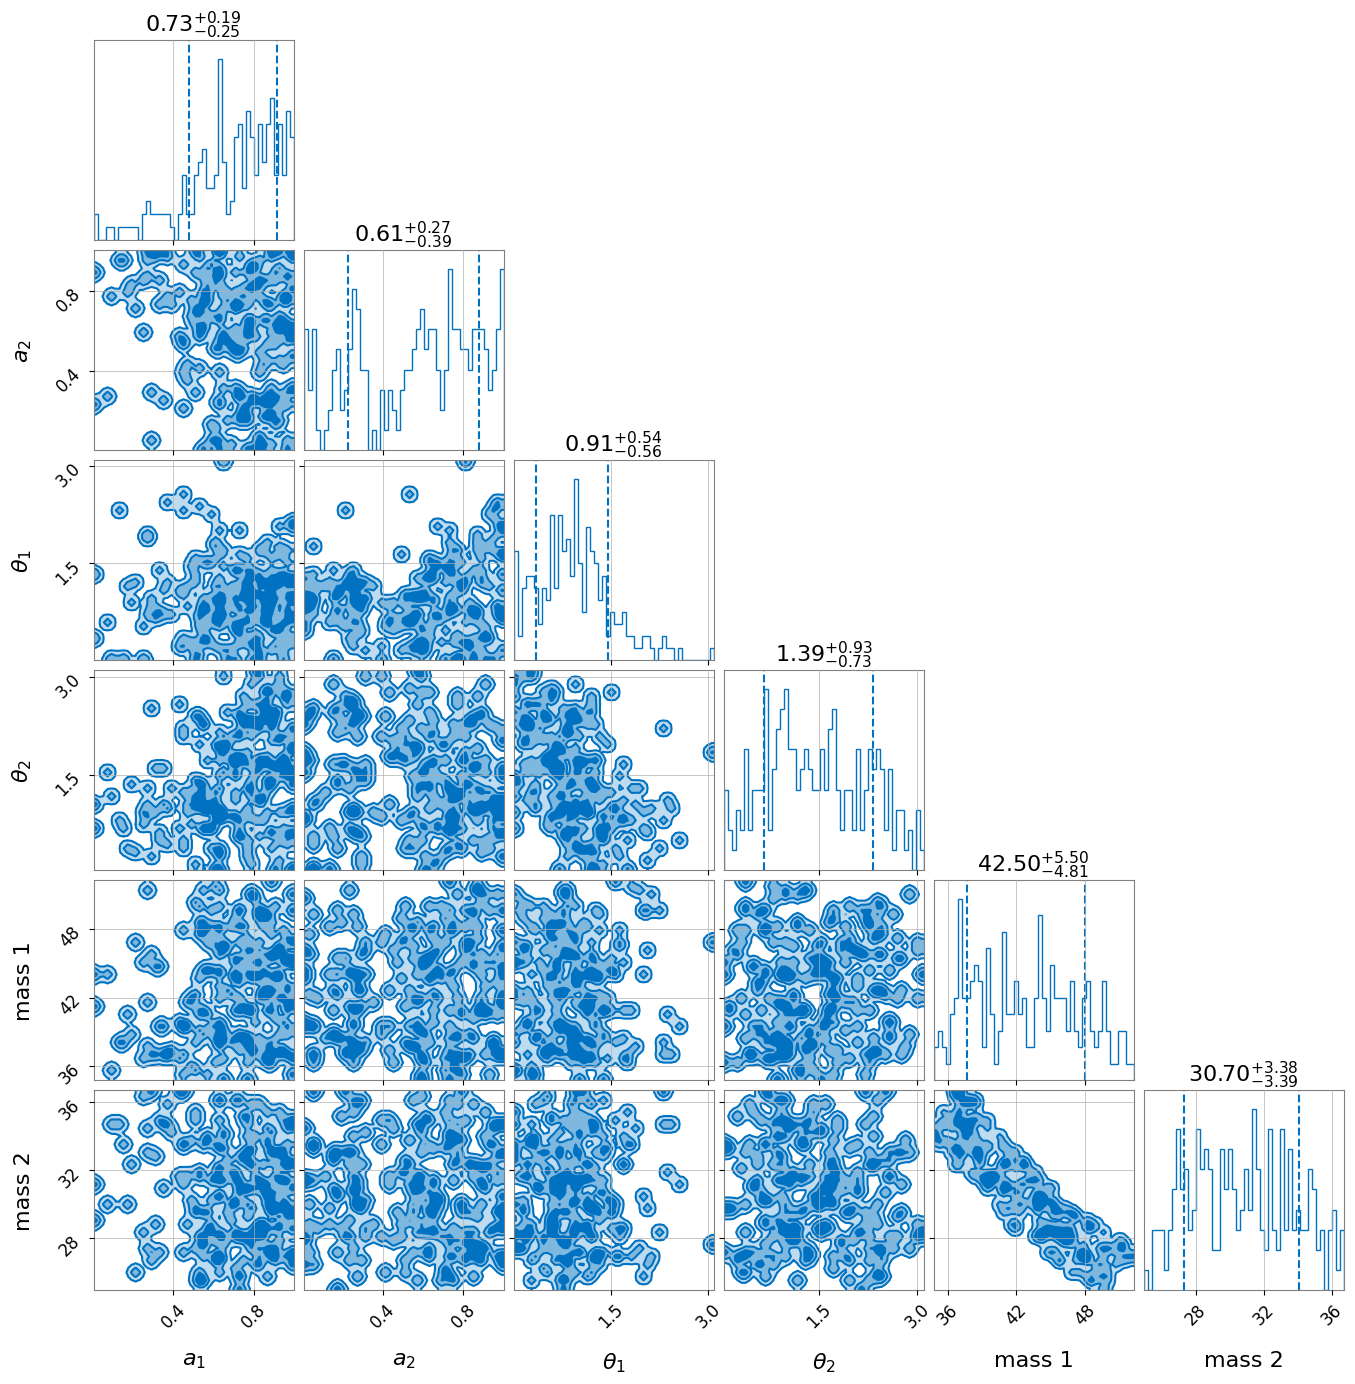

In [40]:
result.plot_corner(parameters=["a_1", "a_2", "tilt_1", "tilt_2", "mass_1", "mass_2"], prior=True)


In [41]:
samps = result.posterior
maxL=np.argmax(samps['log_likelihood'])

best_spin_1 = samps["a_1"][maxL]
best_spin_2 = samps["a_2"][maxL]
best_tilt_1 = samps["tilt_1"][maxL]
best_tilt_2 = samps["tilt_2"][maxL]
best_mass_1 = samps["mass_1"][maxL]
best_mass_2 = samps["mass_2"][maxL]

print("Best spin 1: ", best_spin_1)
print("Best spin 2: ", best_spin_2)
print("Best tilt 1: ", best_tilt_1)
print("Best tilt 2: ", best_tilt_2)

print("Best mass 1: ", best_mass_1)
print("Best mass 2: ", best_mass_2)

Best spin 1:  0.8333364550560577
Best spin 2:  0.860557302285009
Best tilt 1:  0.11163395039842561
Best tilt 2:  2.276758684819431


In [38]:
for key in samps.keys():
    print(key)

chirp_mass
mass_ratio
a_1
a_2
tilt_1
tilt_2
time_jitter
phase
geocent_time
phi_12
phi_jl
dec
ra
theta_jn
psi
luminosity_distance
log_likelihood
log_prior
reference_frequency
waveform_approximant
minimum_frequency
total_mass
mass_1
mass_2
H1_log_likelihood
L1_log_likelihood
H1_matched_filter_snr
H1_optimal_snr
L1_matched_filter_snr
L1_optimal_snr
symmetric_mass_ratio
iota
spin_1x
spin_1y
spin_1z
spin_2x
spin_2y
spin_2z
phi_1
phi_2
chi_eff
chi_1_in_plane
chi_2_in_plane
chi_p
cos_tilt_1
cos_tilt_2
redshift
comoving_distance
mass_1_source
mass_2_source
chirp_mass_source
total_mass_source
